# Chapter 11: Training Deep Neural Networks

This chapter covers techniques to train deep neural networks effectively:

1. **Weight Initialization** - Kaiming (He) initialization to prevent vanishing/exploding gradients
2. **Activation Functions** - LeakyReLU, ELU, SELU, Swish, GELU, SwiGLU, ReLU²
3. **Batch Normalization & Layer Normalization** - Normalizing activations to stabilize training
4. **Transfer Learning** - Reusing pretrained layers for new tasks
5. **Optimizers** - SGD, Momentum, Nesterov, Adagrad, RMSprop, Adam, AdamW
6. **Learning Rate Scheduling** - Exponential, ReduceLROnPlateau, Warmup, Cosine Annealing
7. **Regularization** - L1, L2 (Weight Decay), Dropout, MC Dropout, Max-Norm

In [14]:
import torch 
import torch.nn as nn


In [15]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

## Weight Initialization (Practice)

**Problem:** If weights are too large, activations explode. If too small, they vanish to zero. Both make training impossible.

**Kaiming (He) Initialization** sets weight variance = `2 / fan_in` (number of inputs). This keeps the signal's variance roughly constant across layers when using ReLU.

- Manual: multiply weights by `sqrt(6 / fan_in)` for uniform distribution
- PyTorch built-in: `nn.init.kaiming_uniform_()` or `nn.init.kaiming_normal_()`
- `model.apply(use_he_init)` applies it to every Linear layer at once

In [16]:

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5 # Kaiming initialization
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)      


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [18]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)

model = nn.Sequential(
    nn.Linear(50, 40), nn.ReLU(),
    nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [19]:
alpha = 0.02
model = nn.Sequential(
    nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, a=alpha, nonlinearity="leaky_relu")

Parameter containing:
tensor([[ 0.1267, -0.2888,  0.1188,  ...,  0.1141,  0.3277, -0.1302],
        [ 0.2152, -0.0350,  0.1311,  ..., -0.3366,  0.3433, -0.0038],
        [-0.0026,  0.0491,  0.0237,  ...,  0.1959, -0.0647, -0.1537],
        ...,
        [-0.0724, -0.1092,  0.2029,  ..., -0.0700,  0.0873, -0.1536],
        [ 0.1443,  0.1966, -0.3185,  ..., -0.2316,  0.2025,  0.2274],
        [ 0.1537,  0.2634, -0.2812,  ..., -0.2329,  0.2671, -0.1331]],
       requires_grad=True)

## Batch Normalization & Layer Normalization (Practice)

**Batch Normalization (BN):** Normalizes each feature **across the mini-batch**. For each feature:
`x_hat = (x - mean) / sqrt(var + epsilon)`, then scales/shifts with learnable gamma and beta.

- **Before activation:** `Linear -> BN -> ReLU` (original paper approach)
- **After linear (bias=False):** `Linear(bias=False) -> BN -> ReLU` (preferred — BN already has a bias term beta, so the Linear bias is redundant)
- BN has 4 parameters per feature: `weight` (gamma), `bias` (beta), `running_mean`, `running_var`

**Layer Normalization (LN):** Normalizes **across features within each sample** (not across the batch).
- `nn.LayerNorm([H, W])` normalizes over spatial dimensions only
- `nn.LayerNorm([C, H, W])` normalizes over channels AND spatial dims
- `elementwise_affine=False` removes the learnable gamma/beta

In [20]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1* 28*28), 
    nn.Linear(1*28*28, 300),
    nn.ELU(),
    nn.BatchNorm1d(300, 100),
    nn.Linear(300, 100),
    nn.ELU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
    
)

In [21]:
dict(model[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [22]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ELU(),
    nn.Linear(300, 100),
    nn.BatchNorm1d(100),
    nn.ELU(),
    nn.Linear(100, 10)
    )

In [23]:
input = torch.randn(32, 3, 100, 200)
layer_norm = nn.LayerNorm([100, 200])
resualt = layer_norm(input)

In [24]:
mean = input.mean(dim=[2, 3], keepdim=True) #shape: (32, 3, 1, 1)
vars_ = input.var(dim=[2, 3], keepdim=True, unbiased=False) #shape: (32, 3, 1, 1)
stds = torch.sqrt(vars_ + 1e-5) #shape: (32, 3, 1, 1)
resualt = layer_norm.weight * (input - mean) / stds + layer_norm.bias

In [25]:
layer_norm = nn.LayerNorm([3, 100, 200], elementwise_affine=False)
resualt = layer_norm(input)

---
# Main Chapter Content

The cells below follow the textbook structure with figures and complete examples.

In [27]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

In [28]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

In [29]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

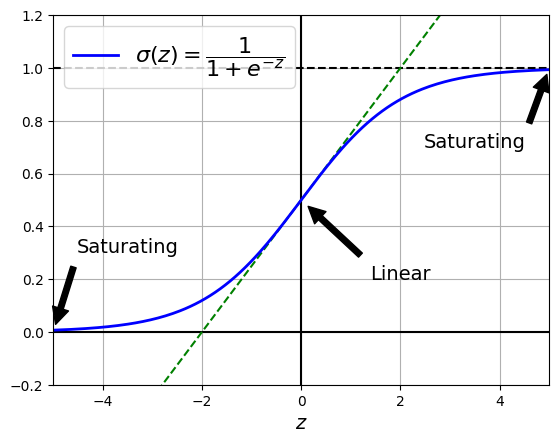

In [30]:
# extra code – this cell generates Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

## The Vanishing/Exploding Gradients Problem

The figure above (Figure 11-1) shows the **sigmoid activation function**. Its derivative is near zero for large positive/negative inputs (saturation regions). During backpropagation, gradients get multiplied through layers:

- If each layer shrinks the gradient slightly -> **vanishing gradients** (lower layers barely learn)
- If each layer amplifies the gradient slightly -> **exploding gradients** (weights oscillate wildly)

**Solution:** Use proper weight initialization + better activation functions (not sigmoid for hidden layers).

In [31]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.data *= 6 ** 0.5  # Kaiming init (or 3 ** 0.5 for LeCun init)
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### Kaiming (He) Initialization

The key idea: initialize weights so the **variance of outputs equals the variance of inputs** at each layer.

| Initialization | Variance | Best for |
|---|---|---|
| **Xavier/Glorot** | `2 / (fan_in + fan_out)` | Sigmoid, Tanh |
| **LeCun** | `1 / fan_in` | SELU |
| **Kaiming/He** | `2 / fan_in` | ReLU, LeakyReLU, ELU |

- `kaiming_uniform_`: samples from uniform distribution scaled by `sqrt(6/fan_in)`
- `kaiming_normal_`: samples from normal distribution with `std = sqrt(2/fan_in)`
- For **LeakyReLU**, pass `a=alpha` (the negative slope) to adjust the formula
- `model.apply(use_he_init)` applies init to all Linear layers recursively

In [61]:
def use_he_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = nn.Sequential(nn.Linear(50, 40), nn.ReLU(), nn.Linear(40, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): ReLU()
  (2): Linear(in_features=40, out_features=1, bias=True)
  (3): ReLU()
)

In [62]:
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=0.2))
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=50, out_features=40, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Activation Functions

Standard **ReLU** (`max(0, z)`) has a problem: neurons that output 0 may never recover (**dying ReLU**). The following alternatives fix this:

### LeakyReLU
`f(z) = max(alpha * z, z)` where alpha is a small slope (e.g., 0.01 or 0.2).
- Allows a small gradient when z < 0, so neurons don't "die"
- Almost no extra computation cost

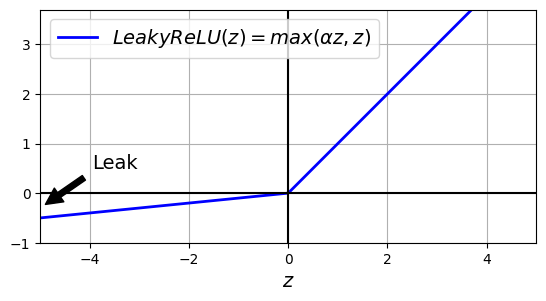

In [63]:
# extra code – this cell generates Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [64]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

In [65]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.ELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### ELU and SELU

**ELU** (Exponential Linear Unit): `f(z) = alpha * (exp(z) - 1)` for z < 0, `z` for z >= 0
- Smoother than LeakyReLU at z=0
- Mean output closer to 0 (helps reduce bias shift)

**SELU** (Scaled ELU): ELU with specific alpha (~1.6733) and lambda (~1.0507) constants
- **Self-normalizing**: activations automatically converge to mean=0, variance=1
- Requirements: must use LeCun normal init, sequential (no skip connections), standardized inputs
- If requirements are met, no need for BatchNorm!

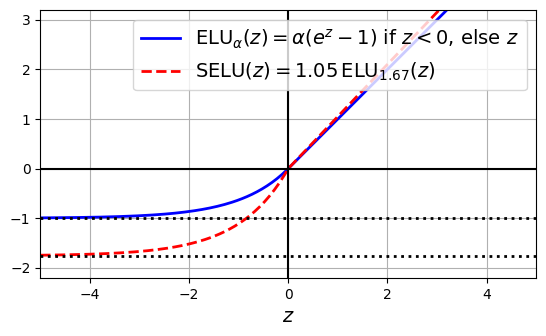

In [66]:
# extra code – this cell generates Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [67]:
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), nn.SELU())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

### Modern Activations: Swish, GELU, SwiGLU, ReLU²

**Swish / SiLU**: `f(z) = z * sigmoid(beta * z)` — smooth, non-monotonic. Used in EfficientNet.

**GELU** (Gaussian Error Linear Unit): `f(z) = z * Phi(z)` approximately equal to `Swish(z, beta=1.702)`. Default activation in Transformers (BERT, GPT).

**SwiGLU** (Swish-Gated Linear Unit): splits input into two halves `z1, z2`, computes `swish(z1) * z2`.
- This is a **gated** activation — one half controls the gate, the other carries the signal
- Used in LLaMA, PaLM, and other modern LLMs
- Requires doubling the intermediate dimension: `nn.Linear(50, 2*40)` for 40 outputs

**ReLU²**: `f(z) = ReLU(z)²` — simply squaring the ReLU output. Recent research shows strong results.

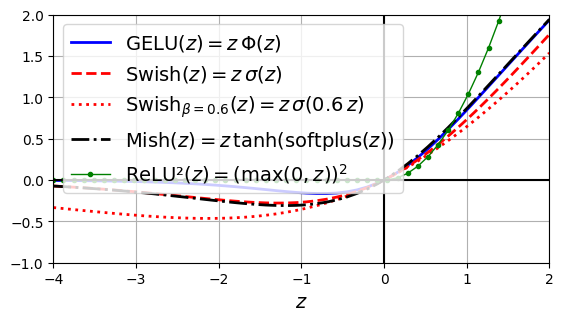

In [68]:
# extra code – this cell generates Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

def relu_squared(z):
    return np.maximum(0, z)**2

z = np.linspace(-4, 2, 50)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "k-.", linewidth=2,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot(z, relu_squared(z), "g.-", linewidth=1,
         label=fr"ReLU²$(z) = (\max(0, z))^2$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

In [69]:
class SwiGLU(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta

    def forward(self, x):
        z1, z2 = x.chunk(2, dim=-1)
        param_swish = z1 * torch.sigmoid(self.beta * z1)
        return param_swish * z2

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 2 * 40), SwiGLU(beta=0.2))
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

In [70]:
import torch.nn.functional as F

class ReLU2(nn.Module):
    def forward(self, x):
        return F.relu(x).square()

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(50, 40), ReLU2())
nn.init.kaiming_uniform_(model[0].weight)
model(torch.rand(2, 50)).shape

torch.Size([2, 40])

## Batch Normalization

Batch Normalization normalizes each feature **across the mini-batch** during training:

1. Compute **mean** and **variance** of each feature across the batch
2. Normalize: `x_hat = (x - batch_mean) / sqrt(batch_var + epsilon)`
3. Scale and shift: `output = gamma * x_hat + beta` (learnable parameters)

During **inference**, BN uses `running_mean` and `running_var` (exponential moving averages computed during training) instead of batch statistics.

**Two placement strategies shown below:**
- **BN before activation** (Cell below): `BN -> Linear -> ReLU -> BN -> Linear -> ReLU`
- **BN after Linear** (next cell): `Linear(bias=False) -> BN -> ReLU` — set `bias=False` because BN's beta already acts as a bias

In [71]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [72]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 300, bias=False),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Linear(300, 100, bias=False),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

### Layer Normalization

Unlike BN (normalizes across batch), **Layer Normalization** normalizes **across features within each individual sample**.

- **BN** computes stats over dimension 0 (batch) -> depends on batch size, behaves differently in train/eval
- **LN** computes stats over the feature dimensions -> independent of batch size, same behavior in train/eval
- **Use BN** for CNNs, **use LN** for Transformers and RNNs

In [73]:
torch.manual_seed(42)

inputs = torch.randn(32, 3, 100, 200)  # a batch of random RGB images
layer_norm = nn.LayerNorm([100, 200])
result = layer_norm(inputs)  # normalizes over the last two dimensions

## Transfer Learning — Reusing Pretrained Layers

**Idea:** Lower layers of a neural network learn general features (edges, textures, basic patterns). We can reuse these layers for a different but related task, instead of training from scratch.

### Workflow:
1. **Train Model A** on a large dataset (here: 8 classes of Fashion-MNIST)
2. **Model B from scratch** on a smaller/different task (binary: sandal vs. T-shirt) — baseline
3. **Model B on A** (transfer learning):
   - Copy all layers except the output from Model A: `copy.deepcopy(model_A[:-1])`
   - Add a new output layer for the new task
   - **Freeze** copied layers: `param.requires_grad = False`
   - Train only the new output layer (fast, avoids destroying pretrained features)
   - **Unfreeze** some/all layers and **fine-tune** with a small learning rate

This typically gives better results, especially when you have limited training data for task B.

In [74]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="Fashion-MNIST", as_frame=False)
X = torch.FloatTensor(fashion_mnist.data.reshape(-1, 1, 28, 28) / 255.)
y = torch.from_numpy(fashion_mnist.target.astype(int))
in_B = (y == 0) | (y == 2)  # Pullover or T-shirt/top
X_A, y_A = X[~in_B], y[~in_B]
y_A = torch.maximum(y_A - 2, torch.tensor(0))  # [1,3,4,5,6,7,8,9] => [0,..,7]
X_B, y_B = X[in_B], (y[in_B] == 2).to(dtype=torch.float32).view(-1, 1)

train_set_A = TensorDataset(X_A[:-7_000], y_A[:-7000])
valid_set_A = TensorDataset(X_A[-7_000:-5000], y_A[-7000:-5000])
test_set_A = TensorDataset(X_A[-5_000:], y_A[-5000:])
train_set_B = TensorDataset(X_B[:20], y_B[:20])
valid_set_B = TensorDataset(X_B[20:5000], y_B[20:5000])
test_set_B = TensorDataset(X_B[5_000:], y_B[5000:])

train_loader_A = DataLoader(train_set_A, batch_size=32, shuffle=True)
valid_loader_A = DataLoader(valid_set_A, batch_size=32)
test_loader_A = DataLoader(test_set_A, batch_size=32)
train_loader_B = DataLoader(train_set_B, batch_size=32, shuffle=True)
valid_loader_B = DataLoader(valid_set_B, batch_size=32)
test_loader_B = DataLoader(test_set_B, batch_size=32)

In [75]:
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            # Uncomment to activate gradient clipping:
            #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(metric.compute().item())
        history["valid_metrics"].append(
            evaluate_tm(model, valid_loader, metric).item())
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
    return history

In [86]:
torch.manual_seed(42)

model_A = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 8)
)
model_A = model_A.to(device)

In [87]:
model_A.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=8, bias=True)
)

In [88]:
n_epochs = 20
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.005)
xentropy = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=8).to(device)
history_A = train(model_A, optimizer, xentropy, accuracy,
                  train_loader_A, valid_loader_A, n_epochs)

Epoch 1/20, train loss: 0.6047, train metric: 0.7973, valid metric: 0.8120
Epoch 2/20, train loss: 0.3421, train metric: 0.8813, valid metric: 0.8870
Epoch 3/20, train loss: 0.2994, train metric: 0.8958, valid metric: 0.8930
Epoch 4/20, train loss: 0.2758, train metric: 0.9037, valid metric: 0.8110
Epoch 5/20, train loss: 0.2608, train metric: 0.9096, valid metric: 0.8700
Epoch 6/20, train loss: 0.2474, train metric: 0.9139, valid metric: 0.9060
Epoch 7/20, train loss: 0.2360, train metric: 0.9181, valid metric: 0.8755
Epoch 8/20, train loss: 0.2278, train metric: 0.9204, valid metric: 0.9120
Epoch 9/20, train loss: 0.2195, train metric: 0.9234, valid metric: 0.9055
Epoch 10/20, train loss: 0.2117, train metric: 0.9261, valid metric: 0.9070
Epoch 11/20, train loss: 0.2065, train metric: 0.9292, valid metric: 0.9150
Epoch 12/20, train loss: 0.2005, train metric: 0.9291, valid metric: 0.8990
Epoch 13/20, train loss: 0.1962, train metric: 0.9304, valid metric: 0.9185
Epoch 14/20, train lo

In [89]:
torch.manual_seed(9)

model_B = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(device)

In [90]:
model_B.apply(use_he_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
)

In [91]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.6575, train metric: 0.7000, valid metric: 0.4871
Epoch 2/20, train loss: 0.6373, train metric: 0.7500, valid metric: 0.5343
Epoch 3/20, train loss: 0.6191, train metric: 0.8500, valid metric: 0.5624
Epoch 4/20, train loss: 0.6030, train metric: 0.9000, valid metric: 0.5753
Epoch 5/20, train loss: 0.5886, train metric: 0.9000, valid metric: 0.5753
Epoch 6/20, train loss: 0.5752, train metric: 0.9000, valid metric: 0.5759
Epoch 7/20, train loss: 0.5628, train metric: 0.9000, valid metric: 0.5785
Epoch 8/20, train loss: 0.5515, train metric: 0.8500, valid metric: 0.5819
Epoch 9/20, train loss: 0.5411, train metric: 0.8500, valid metric: 0.5878
Epoch 10/20, train loss: 0.5314, train metric: 0.8500, valid metric: 0.5944
Epoch 11/20, train loss: 0.5229, train metric: 0.8500, valid metric: 0.6026
Epoch 12/20, train loss: 0.5147, train metric: 0.9000, valid metric: 0.6090
Epoch 13/20, train loss: 0.5068, train metric: 0.9500, valid metric: 0.6159
Epoch 14/20, train lo

In [92]:
evaluate_tm(model_B, test_loader_B, accuracy)

tensor(0.6792, device='cuda:0')

### Transfer Learning Steps (above):

1. **`copy.deepcopy(model_A[:-1])`** — deep copy all layers except the last (output) layer
2. **Freeze layers** — `requires_grad = False` prevents weight updates during backprop
3. **Train the head** (new output layer only) for 10 epochs
4. **Unfreeze layers** — `requires_grad = True` from layer 2 onward
5. **Fine-tune** the entire model for 20 more epochs with the same small learning rate

Compare the result below with Model B trained from scratch above.

In [93]:
import copy

torch.manual_seed(43)
reused_layers = copy.deepcopy(model_A[:-1])
model_B_on_A = nn.Sequential(
    *reused_layers,
    nn.Linear(100, 1)  # new output layer for task B
).to(device)

In [94]:
for layer in model_B_on_A[:-1]:
    for param in layer.parameters():
        param.requires_grad = False

In [95]:
n_epochs = 10
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/10, train loss: 0.9170, train metric: 0.4000, valid metric: 0.4775
Epoch 2/10, train loss: 0.7716, train metric: 0.3500, valid metric: 0.4894
Epoch 3/10, train loss: 0.7005, train metric: 0.4000, valid metric: 0.6622
Epoch 4/10, train loss: 0.6621, train metric: 0.7500, valid metric: 0.6992
Epoch 5/10, train loss: 0.6359, train metric: 0.7500, valid metric: 0.7110
Epoch 6/10, train loss: 0.6144, train metric: 0.8000, valid metric: 0.7221
Epoch 7/10, train loss: 0.5952, train metric: 0.8000, valid metric: 0.7369
Epoch 8/10, train loss: 0.5774, train metric: 0.8000, valid metric: 0.7548
Epoch 9/10, train loss: 0.5607, train metric: 0.8000, valid metric: 0.7767
Epoch 10/10, train loss: 0.5450, train metric: 0.8000, valid metric: 0.7946


In [96]:
for layer in model_B_on_A[2:]:
    for param in layer.parameters():
        param.requires_grad = True

In [97]:
n_epochs = 20
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.005)
xentropy = nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(task="binary").to(device)
history_B = train(model_B_on_A, optimizer, xentropy, accuracy,
                  train_loader_B, valid_loader_B, n_epochs)

Epoch 1/20, train loss: 0.5301, train metric: 0.9000, valid metric: 0.8175
Epoch 2/20, train loss: 0.5127, train metric: 0.9000, valid metric: 0.8339
Epoch 3/20, train loss: 0.4964, train metric: 0.9500, valid metric: 0.8468
Epoch 4/20, train loss: 0.4809, train metric: 0.9500, valid metric: 0.8608
Epoch 5/20, train loss: 0.4664, train metric: 0.9500, valid metric: 0.8705
Epoch 6/20, train loss: 0.4528, train metric: 0.9500, valid metric: 0.8823
Epoch 7/20, train loss: 0.4399, train metric: 0.9500, valid metric: 0.8898
Epoch 8/20, train loss: 0.4278, train metric: 0.9500, valid metric: 0.8964
Epoch 9/20, train loss: 0.4163, train metric: 0.9500, valid metric: 0.8996
Epoch 10/20, train loss: 0.4054, train metric: 1.0000, valid metric: 0.9028
Epoch 11/20, train loss: 0.3951, train metric: 1.0000, valid metric: 0.9068
Epoch 12/20, train loss: 0.3853, train metric: 1.0000, valid metric: 0.9092
Epoch 13/20, train loss: 0.3760, train metric: 1.0000, valid metric: 0.9108
Epoch 14/20, train lo

In [98]:
evaluate_tm(model_B_on_A, test_loader_B, accuracy)

tensor(0.9262, device='cuda:0')

## Optimizers

All optimizers below are tested on the same Fashion-MNIST model to compare convergence speed and final accuracy.

### SGD (Stochastic Gradient Descent)
`w = w - lr * gradient` — vanilla gradient descent. Simple but slow, especially in ravines (narrow valleys in the loss landscape).

### SGD + Momentum
Adds a **velocity** term: `v = momentum * v - lr * gradient`, then `w = w + v`
- Like a ball rolling downhill — accelerates in consistent gradient directions
- `momentum=0.9` is the standard choice
- Helps escape flat regions and speeds up convergence

### Nesterov Accelerated Gradient (NAG)
Computes the gradient at the **look-ahead position** (where momentum would take you), not the current position. Slightly better than standard momentum because it "corrects" before overshooting.

In [99]:
# extra code – a little function to test an optimizer on Fashion MNIST

train_set = TensorDataset(X[:55_000], y[:55_000])
valid_set = TensorDataset(X[55_000:60_000], y[55_000:60_000])
test_set = TensorDataset(X[60_000:], y[60_000:])

def build_model(seed=42):
    torch.manual_seed(seed)
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    model.apply(use_he_init)
    return model

def test_optimizer(model, optimizer, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
    history = train(model, optimizer, xentropy, accuracy.to(device),
                    train_loader, valid_loader, n_epochs)
    return history, evaluate_tm(model, test_loader, accuracy)

In [100]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
history_sgd, acc_sgd = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5531, train metric: 0.7990, valid metric: 0.8488
Epoch 2/10, train loss: 0.3992, train metric: 0.8539, valid metric: 0.8460
Epoch 3/10, train loss: 0.3595, train metric: 0.8677, valid metric: 0.8674
Epoch 4/10, train loss: 0.3354, train metric: 0.8763, valid metric: 0.8674
Epoch 5/10, train loss: 0.3154, train metric: 0.8832, valid metric: 0.8734
Epoch 6/10, train loss: 0.3017, train metric: 0.8887, valid metric: 0.8544
Epoch 7/10, train loss: 0.2888, train metric: 0.8917, valid metric: 0.8762
Epoch 8/10, train loss: 0.2791, train metric: 0.8960, valid metric: 0.8746
Epoch 9/10, train loss: 0.2699, train metric: 0.8989, valid metric: 0.8786
Epoch 10/10, train loss: 0.2588, train metric: 0.9028, valid metric: 0.8682


In [101]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.05)
history_momentum, acc_momentum = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6122, train metric: 0.7777, valid metric: 0.8042
Epoch 2/10, train loss: 0.4766, train metric: 0.8313, valid metric: 0.8568
Epoch 3/10, train loss: 0.4367, train metric: 0.8459, valid metric: 0.8436
Epoch 4/10, train loss: 0.4197, train metric: 0.8516, valid metric: 0.8558
Epoch 5/10, train loss: 0.4001, train metric: 0.8564, valid metric: 0.8558
Epoch 6/10, train loss: 0.3895, train metric: 0.8617, valid metric: 0.8572
Epoch 7/10, train loss: 0.3834, train metric: 0.8633, valid metric: 0.8540
Epoch 8/10, train loss: 0.3749, train metric: 0.8664, valid metric: 0.8650
Epoch 9/10, train loss: 0.3659, train metric: 0.8688, valid metric: 0.8590
Epoch 10/10, train loss: 0.3603, train metric: 0.8710, valid metric: 0.8594


In [102]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9, nesterov=True, lr=0.05)
history_nesterov, acc_nesterov = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5491, train metric: 0.8017, valid metric: 0.8358
Epoch 2/10, train loss: 0.4399, train metric: 0.8414, valid metric: 0.8200
Epoch 3/10, train loss: 0.4079, train metric: 0.8552, valid metric: 0.8380
Epoch 4/10, train loss: 0.3884, train metric: 0.8600, valid metric: 0.8622
Epoch 5/10, train loss: 0.3752, train metric: 0.8642, valid metric: 0.8610
Epoch 6/10, train loss: 0.3663, train metric: 0.8695, valid metric: 0.8610
Epoch 7/10, train loss: 0.3576, train metric: 0.8710, valid metric: 0.8620
Epoch 8/10, train loss: 0.3501, train metric: 0.8747, valid metric: 0.8604
Epoch 9/10, train loss: 0.3441, train metric: 0.8767, valid metric: 0.8628
Epoch 10/10, train loss: 0.3368, train metric: 0.8803, valid metric: 0.8590


### Adaptive Learning Rate Optimizers

These optimizers give each parameter its own adaptive learning rate:

**Adagrad**: Divides LR by the accumulated sum of squared gradients. Parameters with large gradients get smaller LR (and vice versa). Problem: LR keeps shrinking and eventually becomes too small.

**RMSprop**: Fixes Adagrad by using an **exponential moving average** of squared gradients (`alpha=0.9`). The denominator doesn't grow forever.

**Adam** (Adaptive Moment Estimation): Combines **Momentum** (1st moment = mean of gradients) + **RMSprop** (2nd moment = mean of squared gradients). Includes bias correction for early steps. Most popular default optimizer.

**Adamax**: Like Adam but uses L-infinity norm instead of L2 for the 2nd moment. Can be more stable in some cases.

**NAdam**: Adam + Nesterov momentum (look-ahead).

**AdamW**: Adam with **decoupled weight decay**. Standard Adam applies L2 as part of the gradient, which interacts poorly with adaptive LR. AdamW separates them, giving better regularization. **Recommended default for most tasks.**

In [103]:
model = build_model()  # extra code
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)
history_adagrad, acc_adagrad = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.5951, train metric: 0.8087, valid metric: 0.8580
Epoch 2/10, train loss: 0.3775, train metric: 0.8603, valid metric: 0.8524
Epoch 3/10, train loss: 0.3424, train metric: 0.8740, valid metric: 0.8612
Epoch 4/10, train loss: 0.3213, train metric: 0.8807, valid metric: 0.8742
Epoch 5/10, train loss: 0.3041, train metric: 0.8873, valid metric: 0.8720
Epoch 6/10, train loss: 0.2924, train metric: 0.8921, valid metric: 0.8786
Epoch 7/10, train loss: 0.2794, train metric: 0.8955, valid metric: 0.8796
Epoch 8/10, train loss: 0.2701, train metric: 0.8993, valid metric: 0.8782
Epoch 9/10, train loss: 0.2619, train metric: 0.9010, valid metric: 0.8782
Epoch 10/10, train loss: 0.2539, train metric: 0.9060, valid metric: 0.8826


In [104]:
model = build_model()  # extra code
optimizer = torch.optim.RMSprop(model.parameters(), alpha=0.9, lr=0.05)
history_rmsprop, acc_rmsprop = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 2.5116, train metric: 0.4257, valid metric: 0.4300
Epoch 2/10, train loss: 1.5943, train metric: 0.3915, valid metric: 0.3436
Epoch 3/10, train loss: 1.5863, train metric: 0.3741, valid metric: 0.3474
Epoch 4/10, train loss: 1.6780, train metric: 0.3432, valid metric: 0.3448
Epoch 5/10, train loss: 1.6814, train metric: 0.3451, valid metric: 0.3422
Epoch 6/10, train loss: 1.7716, train metric: 0.3376, valid metric: 0.2966
Epoch 7/10, train loss: 1.8044, train metric: 0.3100, valid metric: 0.2482
Epoch 8/10, train loss: 1.9746, train metric: 0.2491, valid metric: 0.3044
Epoch 9/10, train loss: 1.7152, train metric: 0.3287, valid metric: 0.3476
Epoch 10/10, train loss: 1.8254, train metric: 0.2858, valid metric: 0.2688


In [105]:
model = build_model()  # extra code
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adam, acc_adam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.3088, train metric: 0.5201, valid metric: 0.4612
Epoch 2/10, train loss: 1.2441, train metric: 0.4781, valid metric: 0.5060
Epoch 3/10, train loss: 1.1878, train metric: 0.4949, valid metric: 0.5164
Epoch 4/10, train loss: 1.2842, train metric: 0.4457, valid metric: 0.5224
Epoch 5/10, train loss: 1.6626, train metric: 0.3353, valid metric: 0.1930
Epoch 6/10, train loss: 1.9124, train metric: 0.1892, valid metric: 0.1438
Epoch 7/10, train loss: 1.8068, train metric: 0.1913, valid metric: 0.2006
Epoch 8/10, train loss: 1.9468, train metric: 0.1930, valid metric: 0.1932
Epoch 9/10, train loss: 1.9918, train metric: 0.1922, valid metric: 0.1646
Epoch 10/10, train loss: 2.0433, train metric: 0.1800, valid metric: 0.1732


In [106]:
model = build_model()  # extra code
optimizer = torch.optim.Adamax(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_adamax, acc_adamax = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 0.6496, train metric: 0.7897, valid metric: 0.7970
Epoch 2/10, train loss: 0.4875, train metric: 0.8278, valid metric: 0.8370
Epoch 3/10, train loss: 0.4552, train metric: 0.8413, valid metric: 0.8438
Epoch 4/10, train loss: 0.4338, train metric: 0.8475, valid metric: 0.8504
Epoch 5/10, train loss: 0.4226, train metric: 0.8518, valid metric: 0.8420
Epoch 6/10, train loss: 0.4136, train metric: 0.8554, valid metric: 0.8558
Epoch 7/10, train loss: 0.4059, train metric: 0.8564, valid metric: 0.8544
Epoch 8/10, train loss: 0.3966, train metric: 0.8593, valid metric: 0.8428
Epoch 9/10, train loss: 0.3935, train metric: 0.8614, valid metric: 0.8590
Epoch 10/10, train loss: 0.3881, train metric: 0.8629, valid metric: 0.8562


In [107]:
model = build_model()  # extra code
optimizer = torch.optim.NAdam(model.parameters(), betas=(0.9, 0.999), lr=0.05)
history_nadam, acc_nadam = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.8612, train metric: 0.2948, valid metric: 0.1980
Epoch 2/10, train loss: 1.7414, train metric: 0.1997, valid metric: 0.1834
Epoch 3/10, train loss: 1.7682, train metric: 0.1999, valid metric: 0.2052
Epoch 4/10, train loss: 1.7304, train metric: 0.1989, valid metric: 0.1928
Epoch 5/10, train loss: 1.7307, train metric: 0.2017, valid metric: 0.1964
Epoch 6/10, train loss: 1.8325, train metric: 0.1935, valid metric: 0.1994
Epoch 7/10, train loss: 1.7407, train metric: 0.1960, valid metric: 0.2024
Epoch 8/10, train loss: 1.7337, train metric: 0.1995, valid metric: 0.1978
Epoch 9/10, train loss: 1.7731, train metric: 0.1948, valid metric: 0.2000
Epoch 10/10, train loss: 1.7275, train metric: 0.1959, valid metric: 0.2046


In [108]:
model = build_model()  # extra code
optimizer = torch.optim.AdamW(model.parameters(), betas=(0.9, 0.999),
                              weight_decay=1e-5, lr=0.05)
history_adamw, acc_adamw = test_optimizer(model, optimizer)  # extra code

Epoch 1/10, train loss: 1.1314, train metric: 0.6028, valid metric: 0.4384
Epoch 2/10, train loss: 1.4123, train metric: 0.4059, valid metric: 0.4202
Epoch 3/10, train loss: 1.4057, train metric: 0.3964, valid metric: 0.3914
Epoch 4/10, train loss: 1.3832, train metric: 0.3993, valid metric: 0.4318
Epoch 5/10, train loss: 1.3774, train metric: 0.4049, valid metric: 0.4186
Epoch 6/10, train loss: 1.3580, train metric: 0.4111, valid metric: 0.4088
Epoch 7/10, train loss: 1.3951, train metric: 0.4082, valid metric: 0.3656
Epoch 8/10, train loss: 1.3791, train metric: 0.4193, valid metric: 0.3878
Epoch 9/10, train loss: 1.3250, train metric: 0.4153, valid metric: 0.4206
Epoch 10/10, train loss: 1.3057, train metric: 0.4118, valid metric: 0.4326


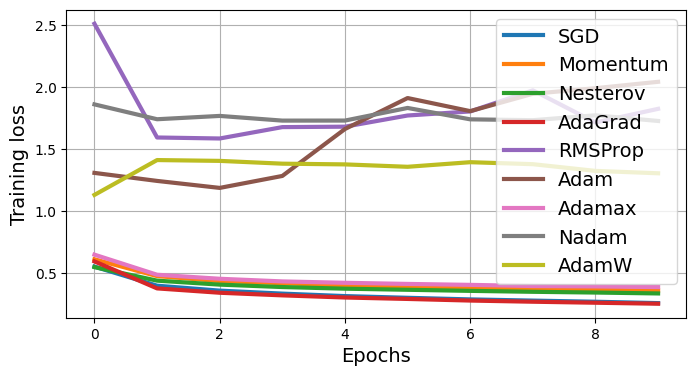

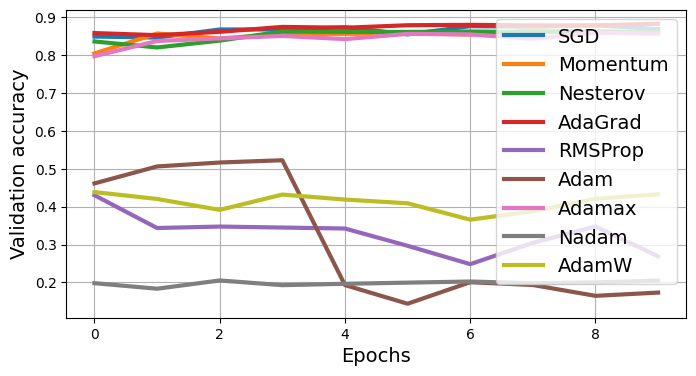

In [109]:
# extra code – visualize the learning curves of all the optimizers

for plot in ("train_losses", "valid_metrics"):
    plt.figure(figsize=(8, 4))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip(
        (history_sgd, history_momentum, history_nesterov, history_adagrad,
         history_rmsprop, history_adam, history_adamax, history_nadam,
         history_adamw), opt_names.split()):
        plt.plot(history[plot], label=opt_name, linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"train_losses": "Training loss", "valid_metrics": "Validation accuracy"}[plot])
    plt.legend(loc="upper right")
    plt.show()

## Learning Rate Scheduling

A fixed learning rate is rarely optimal. Schedules adjust the LR during training:

### ExponentialLR
`lr = lr * gamma^epoch` — decays by a constant factor each epoch. Simple but aggressive.

### ReduceLROnPlateau
Monitors a metric (e.g., validation accuracy). If no improvement for `patience` epochs, reduces LR by `factor`. Adaptive — only reduces when needed.

### LinearLR (Warmup)
Gradually increases LR from `start_factor * lr` to `lr` over `total_iters` steps.
- Prevents instability at the start of training when gradients are large and noisy
- Especially important for Adam-family optimizers and Transformers

### LambdaLR
Custom schedule via a lambda function. Flexible — you can implement any schedule.

In [110]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [111]:
def train_with_scheduler(model, optimizer, loss_fn, metric, train_loader,
                         valid_loader, n_epochs, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        losses = []
        metric.reset()
        for X_batch, y_batch in train_loader:
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_metric)
        else:
            scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_scheduler(model, optimizer, scheduler, n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_scheduler(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [112]:
history_exp, acc_exp = test_scheduler(model, optimizer, exp_scheduler)  # extra code

Epoch 1/10, train loss: 0.5531, train metric: 0.7990, valid metric: 0.8488
Learning rate: 0.04500
Epoch 2/10, train loss: 0.3942, train metric: 0.8561, valid metric: 0.8424
Learning rate: 0.04050
Epoch 3/10, train loss: 0.3534, train metric: 0.8706, valid metric: 0.8664
Learning rate: 0.03645
Epoch 4/10, train loss: 0.3279, train metric: 0.8792, valid metric: 0.8738
Learning rate: 0.03281
Epoch 5/10, train loss: 0.3064, train metric: 0.8864, valid metric: 0.8746
Learning rate: 0.02952
Epoch 6/10, train loss: 0.2912, train metric: 0.8932, valid metric: 0.8740
Learning rate: 0.02657
Epoch 7/10, train loss: 0.2770, train metric: 0.8968, valid metric: 0.8768
Learning rate: 0.02391
Epoch 8/10, train loss: 0.2660, train metric: 0.9019, valid metric: 0.8762
Learning rate: 0.02152
Epoch 9/10, train loss: 0.2559, train metric: 0.9053, valid metric: 0.8786
Learning rate: 0.01937
Epoch 10/10, train loss: 0.2457, train metric: 0.9091, valid metric: 0.8778
Learning rate: 0.01743


In [113]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)

In [114]:
history_perf, acc_perf = test_scheduler(model, optimizer, perf_scheduler)  # extra code

Epoch 1/10, train loss: 0.5531, train metric: 0.7990, valid metric: 0.8488
Learning rate: 0.05000
Epoch 2/10, train loss: 0.3992, train metric: 0.8539, valid metric: 0.8460
Learning rate: 0.05000
Epoch 3/10, train loss: 0.3595, train metric: 0.8677, valid metric: 0.8674
Learning rate: 0.05000
Epoch 4/10, train loss: 0.3354, train metric: 0.8763, valid metric: 0.8674
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3154, train metric: 0.8832, valid metric: 0.8734
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3017, train metric: 0.8887, valid metric: 0.8544
Learning rate: 0.05000
Epoch 7/10, train loss: 0.2888, train metric: 0.8917, valid metric: 0.8762
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2791, train metric: 0.8960, valid metric: 0.8746
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2699, train metric: 0.8989, valid metric: 0.8786
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2588, train metric: 0.9028, valid metric: 0.8682
Learning rate: 0.05000


In [115]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=0.1, end_factor=1.0, total_iters=3)

In [116]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda epoch: (min(epoch, 3) / 3) * (1.0 - 0.1) + 0.1)

In [117]:
# extra code
def train_with_warmup(model, optimizer, loss_fn, metric, train_loader,
                      valid_loader, n_epochs, warmup_scheduler, scheduler):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):

        warmup_scheduler.step()

        # extra code
        losses = []
        metric.reset()

        for X_batch, y_batch in train_loader:

            # extra code
            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            metric.update(y_pred, y_batch)
        history["train_losses"].append(np.mean(losses))
        history["train_metrics"].append(metric.compute().item())
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        print(f"Epoch {epoch + 1}/{n_epochs}, "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.4f}, "
              f"valid metric: {history['valid_metrics'][-1]:.4f}")

        if epoch >= 3:  # deactivate other scheduler(s) during warmup
            scheduler.step(val_metric)

        # extra code
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.5f}")
    return history

def test_warmup_scheduler(model, optimizer, warmup_scheduler, scheduler,
                          n_epochs=10, batch_size=32):
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    xentropy = nn.CrossEntropyLoss()
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    history = train_with_warmup(
        model, optimizer, xentropy, metric, train_loader, valid_loader,
        n_epochs, warmup_scheduler, scheduler)
    return history, evaluate_tm(model, test_loader, metric)

In [118]:
perf_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.1)
test_warmup_scheduler(model, optimizer, warmup_scheduler, perf_scheduler,
                      n_epochs=10, batch_size=32)

c:\Users\Ah\pytorch_amd\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/10, train loss: 0.6057, train metric: 0.7855, valid metric: 0.8426
Learning rate: 0.00500
Epoch 2/10, train loss: 0.4423, train metric: 0.8405, valid metric: 0.8450
Learning rate: 0.00500
Epoch 3/10, train loss: 0.3998, train metric: 0.8533, valid metric: 0.8570
Learning rate: 0.00500
Epoch 4/10, train loss: 0.3601, train metric: 0.8676, valid metric: 0.8698
Learning rate: 0.05000
Epoch 5/10, train loss: 0.3339, train metric: 0.8764, valid metric: 0.8756
Learning rate: 0.05000
Epoch 6/10, train loss: 0.3165, train metric: 0.8828, valid metric: 0.8708
Learning rate: 0.05000
Epoch 7/10, train loss: 0.2995, train metric: 0.8890, valid metric: 0.8768
Learning rate: 0.05000
Epoch 8/10, train loss: 0.2881, train metric: 0.8936, valid metric: 0.8740
Learning rate: 0.05000
Epoch 9/10, train loss: 0.2779, train metric: 0.8958, valid metric: 0.8800
Learning rate: 0.05000
Epoch 10/10, train loss: 0.2669, train metric: 0.9006, valid metric: 0.8570
Learning rate: 0.05000


({'train_losses': [np.float64(0.6056709847845887),
   np.float64(0.4422754604562276),
   np.float64(0.3997850584092703),
   np.float64(0.360108937287986),
   np.float64(0.3339443790849348),
   np.float64(0.31652692245311903),
   np.float64(0.29946667082074635),
   np.float64(0.28809677899195885),
   np.float64(0.2779476171226142),
   np.float64(0.2668874052035177)],
  'train_metrics': [0.7854727506637573,
   0.8405091166496277,
   0.8532727360725403,
   0.867618203163147,
   0.8763636350631714,
   0.8827636241912842,
   0.889018177986145,
   0.8935999870300293,
   0.895836353302002,
   0.900563657283783],
  'valid_metrics': [0.8425999879837036,
   0.8450000286102295,
   0.8569999933242798,
   0.8697999715805054,
   0.8755999803543091,
   0.8708000183105469,
   0.876800000667572,
   0.8740000128746033,
   0.8799999952316284,
   0.8569999933242798]},
 tensor(0.8501, device='cuda:0'))

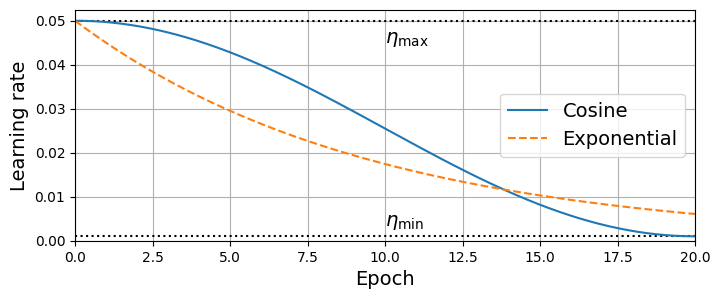

In [119]:
t = np.linspace(0, 20, 400)
eta_min = 0.001
eta_max = 0.05
t2 = 20
eta_cos_t = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(t / t2 * np.pi))
eta_exp_t = 0.9 ** t * eta_max

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 20, color="k", linestyle="dotted")
plt.plot(t, eta_cos_t, label="Cosine")
plt.plot(t, eta_exp_t, "--", label="Exponential")
plt.legend(loc="center right")
plt.text(10, eta_min + 0.0025, r"$\eta_\text{min}$")
plt.text(10, eta_max - 0.005, r"$\eta_\text{max}$")
plt.axis([0, 20, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

### Cosine Annealing

**CosineAnnealingLR**: `lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + cos(pi * t / T_max))`
- Smoothly decreases LR from `eta_max` to `eta_min` following a cosine curve
- Decays slowly at first, then faster in the middle, then slowly again at the end
- Much smoother than exponential decay (see plot above)

**CosineAnnealingWarmRestarts**: Same cosine curve but **restarts** periodically.
- `T_0`: number of epochs for the first restart cycle
- `T_mult`: multiplier for subsequent cycle lengths (e.g., T_mult=2 doubles each cycle)
- Warm restarts help the model escape local minima by temporarily increasing the LR

**Modern default:** Warmup + Cosine Annealing (used in most Transformer training).

In [120]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20, eta_min=0.001)

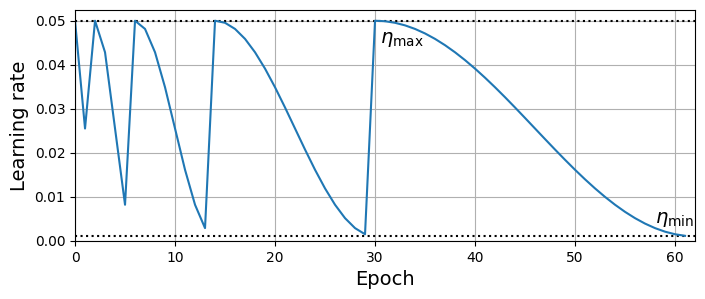

In [121]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # or any other optim.
cosine_repeat_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=2, T_mult=2, eta_min=0.001)

lrs = []
for epoch in range(62):
    lrs.append(cosine_repeat_scheduler.get_last_lr()[0])
    cosine_repeat_scheduler.step()

plt.figure(figsize=(8, 3))
plt.hlines([eta_min, eta_max], 0, 64, color="k", linestyle="dotted")
plt.plot(lrs, label="Cosine")
plt.text(30.5, eta_max - 0.005, r"$\eta_\text{max}$")
plt.text(58, eta_min + 0.003, r"$\eta_\text{min}$")
plt.axis([0, 62, 0, eta_max * 1.05])
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

In [122]:
import re

DOCS_URL = "https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler"
for name in sorted(dir(torch.optim.lr_scheduler)):
    scheduler = getattr(torch.optim.lr_scheduler, name)
    if (not name.startswith("_") and isinstance(scheduler, type) and
        issubclass(scheduler, torch.optim.lr_scheduler.LRScheduler)):
            print(f"• {DOCS_URL}.{name}.html")

• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ChainedScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ConstantLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
• https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiplicativeLR.html
• https://pytorch.org/docs/sta

## Regularization

Regularization techniques prevent overfitting by constraining the model.

### L2 Regularization (Weight Decay)
Adds `lambda * ||w||^2` to the loss. Penalizes large weights, keeping them small.
- **Simple way:** `weight_decay=1e-4` parameter in the optimizer (applies to all params)
- **Manual way:** compute `sum(param^2)` and add to loss — gives more control
- **Per-parameter groups:** different weight_decay for weights vs biases (typically 0 for biases and BN params)

### L1 Regularization
Adds `lambda * ||w||_1` (sum of absolute values) to the loss.
- Encourages **sparsity** — drives some weights to exactly zero
- Useful for feature selection (unimportant features get zeroed out)
- Applied manually by adding `torch.sum(torch.abs(param))` to the loss

In [123]:
model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
history = test_optimizer(model, optimizer)

Epoch 1/10, train loss: 0.5521, train metric: 0.7999, valid metric: 0.8480
Epoch 2/10, train loss: 0.4001, train metric: 0.8526, valid metric: 0.8544
Epoch 3/10, train loss: 0.3605, train metric: 0.8666, valid metric: 0.8642
Epoch 4/10, train loss: 0.3375, train metric: 0.8753, valid metric: 0.8710
Epoch 5/10, train loss: 0.3168, train metric: 0.8842, valid metric: 0.8728
Epoch 6/10, train loss: 0.3047, train metric: 0.8866, valid metric: 0.8636
Epoch 7/10, train loss: 0.2912, train metric: 0.8909, valid metric: 0.8784
Epoch 8/10, train loss: 0.2825, train metric: 0.8946, valid metric: 0.8756
Epoch 9/10, train loss: 0.2732, train metric: 0.8981, valid metric: 0.8772
Epoch 10/10, train loss: 0.2639, train metric: 0.9018, valid metric: 0.8604


In [124]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l2_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l2_loss = sum(param.pow(2.0).sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l2_loss
        total_loss += loss.item()
        total_l2_loss += l2_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l2 loss: {total_l2_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l2 loss: 640.213 – loss: 0.617
Epoch 2/3 – l2 loss: 648.439 – loss: 0.464
Epoch 3/3 – l2 loss: 648.868 – loss: 0.425


In [125]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
params_bias_and_bn = [
    param for name, param in model.named_parameters()
    if "bias" in name or "bn" in name]
optimizer = torch.optim.SGD([
    {"params": params_to_regularize, "weight_decay": 1e-4},
    {"params": params_bias_and_bn, "weight_decay": 0},
    ], lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.552
Epoch 2/3 – loss: 0.399
Epoch 3/3 – loss: 0.359


In [126]:
n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
params_to_regularize = [
    param for name, param in model.named_parameters()
    if not "bias" in name and not "bn" in name]
for epoch in range(n_epochs):
    total_loss = 0.0
    total_l1_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        main_loss = loss_fn(y_pred, y_batch)
        l1_loss = sum(param.abs().sum() for param in params_to_regularize)
        loss = main_loss + 1e-4 * l1_loss
        total_loss += loss.item()
        total_l1_loss += l1_loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – l1 loss: {total_l1_loss / len(train_loader):.3f}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – l1 loss: 5279.536 – loss: 1.085
Epoch 2/3 – l1 loss: 4731.494 – loss: 0.882
Epoch 3/3 – l1 loss: 4241.989 – loss: 0.798


### Dropout

During **training**: randomly sets each neuron to 0 with probability `p` (e.g., p=0.2).
- Forces the network to not rely on any single neuron
- Acts like training an ensemble of smaller networks
- Each forward pass uses a different random subset of neurons

During **inference** (`model.eval()`): all neurons are active, outputs are NOT scaled (PyTorch Dropout uses "inverted dropout" which scales during training instead).

Place `nn.Dropout(p)` **before** each layer you want to regularize.

In [127]:
torch.manual_seed(42)
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), nn.Linear(28 * 28, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 100), nn.ReLU(),
    nn.Dropout(p=0.2), nn.Linear(100, 10)
).to(device)
model.apply(use_he_init)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
history_dropout, acc_dropout = test_optimizer(model, optimizer, batch_size=32)

Epoch 1/10, train loss: 0.6817, train metric: 0.7502, valid metric: 0.8366
Epoch 2/10, train loss: 0.5134, train metric: 0.8128, valid metric: 0.8528
Epoch 3/10, train loss: 0.4781, train metric: 0.8243, valid metric: 0.8542
Epoch 4/10, train loss: 0.4538, train metric: 0.8365, valid metric: 0.8602
Epoch 5/10, train loss: 0.4355, train metric: 0.8399, valid metric: 0.8510
Epoch 6/10, train loss: 0.4266, train metric: 0.8430, valid metric: 0.8654
Epoch 7/10, train loss: 0.4140, train metric: 0.8479, valid metric: 0.8676
Epoch 8/10, train loss: 0.4072, train metric: 0.8496, valid metric: 0.8774
Epoch 9/10, train loss: 0.4024, train metric: 0.8524, valid metric: 0.8728
Epoch 10/10, train loss: 0.3929, train metric: 0.8559, valid metric: 0.8706


In [128]:
model.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()

X_new = torch.FloatTensor(fashion_mnist.data[:3].reshape(3, 1, 28, 28) / 255)
X_new = X_new.to(device)

torch.manual_seed(42)
with torch.no_grad():
    X_new_repeated = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model(X_new_repeated).reshape(3, 100, 10)
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)

In [129]:
y_probas.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000,
         0.9800],
        [0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000,
         0.0000],
        [0.4800, 0.0200, 0.0200, 0.1900, 0.0200, 0.0000, 0.2700, 0.0000, 0.0000,
         0.0000]], device='cuda:0')

### MC Dropout (Monte Carlo Dropout)

**Idea:** Keep dropout **active during inference** to get **uncertainty estimates**.

1. Override `forward()` to always use `training=True` in `F.dropout`
2. Run the same input through the model **many times** (e.g., 100)
3. Each pass gives a slightly different prediction (due to random dropout)
4. **Average** the predictions for a better estimate
5. The **spread** (variance) tells you how **uncertain** the model is

If predictions vary a lot across runs -> the model is unsure about that input.
If predictions are consistent -> the model is confident.

```python
class McDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)  # always drops!
```

In [130]:
class McDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)

In [131]:
class McDropout(nn.Dropout):
    def forward(self, input):
        return F.dropout(input, self.p, training=True)

In [132]:
def mean_prediction(model, X, n_repeats):
    X_new_repeated = X_new.repeat_interleave(n_repeats, dim=0)
    y_logits = model(X_new_repeated)
    y_logits_all = y_logits.reshape(X.shape[0], n_repeats, *y_logits.shape[1:])
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    return y_probas_all.mean(dim=1)

In [133]:
with torch.no_grad():
  y_mean_pred = mean_prediction(model, X_new, 100)

y_mean_pred.round(decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0300, 0.0000,
         0.9700],
        [0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0200, 0.0000, 0.0000,
         0.0000],
        [0.4900, 0.0200, 0.0200, 0.1800, 0.0200, 0.0000, 0.2700, 0.0000, 0.0000,
         0.0000]], device='cuda:0')

### Max-Norm Regularization

After each training step, **clip** each weight vector so its L2 norm doesn't exceed `max_norm`:

`if ||w|| > max_norm: w = w * (max_norm / ||w||)`

- Applied manually after `optimizer.step()` (not built into PyTorch optimizers)
- Prevents any single weight vector from becoming too large
- Different from L2: L2 continuously pushes weights toward 0, while max-norm only clips when they exceed the threshold
- Often used together with Dropout

In [134]:
def apply_max_norm(model, max_norm=2, epsilon=1e-8, dim=1):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'bias' not in name:
                actual_norm = param.norm(p=2, dim=dim, keepdim=True)
                target_norm = torch.clamp(actual_norm, 0, max_norm)
                param *= target_norm / (epsilon + actual_norm)

In [ ]:
torch.manual_seed(42)

n_epochs = 3
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()

model = build_model()  # extra code
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
for epoch in range(n_epochs):
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        apply_max_norm(model)
    print(f"Epoch {epoch + 1}/{n_epochs}"
          f" – loss: {total_loss / len(train_loader):.3f}")

Epoch 1/3 – loss: 0.553
